In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import multiprocessing as mp
import pandas as pd
import re
import scipy.stats as stats
from scipy.interpolate import UnivariateSpline
from scipy.optimize import bisect, leastsq
from glob import glob

In [3]:
Tc = 8.77846

In [4]:
kw = dict(columns=['M2','M4'])

with pd.get_store('/home/matt/Dropbox/data/fss/data.h5') as store:
    data = pd.concat([store.select('old/free', **kw).xs(0, level='k'),
                      store.select('new/free', where='L != 48', **kw)])
    
data.index.names = [s if s != 'Stage' else 'LogSweeps' for s in data.index.names] # rename
dataTc = data.query('Temp > 8.77845')
data = data.query('Temp < 8.77845') # exclude data at bulk T_c

In [5]:
data.head()

M2        M4
L Temp     LogSweeps Run                    
8 7.750308 4         0    0.054738  0.003106
                     1    0.056092  0.003275
                     2    0.053007  0.002916
                     3    0.044488  0.002058
                     4    0.059542  0.003698

In [6]:
chi = data.eval('L**5 * M2').groupby(level=['L','Temp','LogSweeps']).agg(['mean','sem'])

In [7]:
chi.head()

mean        sem
L Temp     LogSweeps                        
8 7.750308 4          1793.691090  11.068571
           5          1812.544686   7.198004
           6          1822.595403   5.635580
           7          1814.162616   3.885820
           8          1821.525728   2.527130

In [8]:
def binderG(df):
    n = len(df)
    xj = (df.sum() - df) / (n - 1.)
    gj = xj.eval('0.5*(3. - M4/M2**2)')
    return pd.Series({'mean': gj.mean(), 'sem': sqrt(n) * gj.std()})

In [9]:
G = data.groupby(level=['L','Temp','LogSweeps']).apply(binderG)

In [10]:
G.head()

mean       sem
L Temp     LogSweeps                    
8 7.750308 4          0.980311  0.000781
           5          0.979589  0.000593
           6          0.980206  0.000446
           7          0.980527  0.000275
           8          0.980189  0.000203

In [11]:
result = pd.concat({'chi': chi, 'G': G}, axis=1)

In [12]:
result.head()

G                    chi           
                          mean       sem         mean        sem
L Temp     LogSweeps                                            
8 7.750308 4          0.980311  0.000781  1793.691090  11.068571
           5          0.979589  0.000593  1812.544686   7.198004
           6          0.980206  0.000446  1822.595403   5.635580
           7          0.980527  0.000275  1814.162616   3.885820
           8          0.980189  0.000203  1821.525728   2.527130

# Bootstrap $T_L$ and $\chi(T_L)$

### Find the value $T_L$ by splining

In [ ]:
y = 0.5
df = result.xs([32,10], level=['L','LogSweeps'])
df.G.plot(y='mean', yerr='sem', marker='o')
axhline(0.5, color='k', ls='--')
f = UnivariateSpline(df.index, df.G['mean'], w=1./df.G['sem'])
TL = bisect(lambda T: y - f(T), df.index[0], df.index[-1])
axvline(TL, color='r')

### Find the value of $\chi(T_L)$

In [ ]:
df.chi.plot(y='mean', yerr='sem', marker='o')
f = UnivariateSpline(df.index, df.chi['mean'], w=1./df.chi['sem'])
axvline(TL, color='k', ls='--')
axhline(f(TL), color='r')

## Bootstrap

In [ ]:
def findTL(df, y=0.5):
    
    try:
        fG = UnivariateSpline(df.index, df.G['mean'], w=1./df.G['sem'])
        TL = bisect(lambda T: y - fG(T), df.index[0], df.index[-1])
        fChi = UnivariateSpline(df.index, df.chi['mean'], w=1./df.chi['sem'])
        chi = fChi(TL).item()
        
    except ValueError as e:
        TL = nan
        chi = nan
        
    return pd.Series({'TL': TL, 'chiTL': chi})

In [ ]:
def compute_TL_chi(data):
    groupby = ['L','Temp','LogSweeps']
    chi = data.eval('L**5 * M2').groupby(level=groupby).agg(['mean','sem'])
    G = data.groupby(level=groupby).apply(binderG)
    df = pd.concat({'chi': chi, 'G': G}, axis=1)
    result = df.groupby(level=['L','LogSweeps']).apply(lambda df: findTL(df.reset_index(['L','LogSweeps'])))
    return result

In [ ]:
df = compute_TL_chi(data)
df.head()

In [ ]:
yy = Tc - df['TL']
yy = yy.groupby(level='L').apply(lambda x: x.iloc[argmax(x.index.get_level_values('LogSweeps'))])
yy.plot(ls='', marker='s')
y = yy[-3:]
p = polyfit(log(y.index), log(y.values), 1)
plot(yy.index, exp(polyval(p, log(yy.index))))
xscale('log', basex=2)
yscale('log')
title(r'$\lambda \approx {:.3g}$'.format(-p[0]));

In [297]:
def bootstrap_sample(groups):
    return groups.apply(lambda x: x.take(random_integers(0, len(x)-1, len(x))))


class BootstrapSampler:
    
    def __init__(self, data, groupby, reducer):
        self.data = data
        self.groupby = groupby
        self.reducer = reducer
        
    def __call__(self, seed):
        random.seed(seed)
        resamp = bootstrap_sample(self.data.groupby(level=self.groupby, group_keys=False))
        return self.reducer(resamp)

In [ ]:
data.head()

In [ ]:
seeds = random_integers(1e5, size=100)
bs = BootstrapSampler(data, ['L','Temp','LogSweeps'], compute_TL_chi)

with mp.Pool(4) as p:
    samples = p.map(bs, seeds)

samples = pd.concat(samples, keys=seeds, names=['seed'])

In [ ]:
#samples.to_hdf('chi-TL-samples.h5','samples')

In [108]:
samples = pd.read_hdf('chi-TL-samples.h5','samples').sortlevel()

In [109]:
samples.head()

TL       chiTL
seed  L LogSweeps                      
10052 8 4          8.038827  174.824965
        5          8.035035  175.512958
        6          8.030586  185.954535
        7          8.037749  175.599246
        8          8.035567  176.590985

In [110]:
def get_final(df):
    b = df.index.get_level_values('LogSweeps')
    return df.reset_index('LogSweeps', drop=True).iloc[b == b.max()]

In [111]:
samples_final = (samples.groupby(level=['seed','L'], group_keys=False)
                        .apply(get_final))

#$\Delta T_L$ (shift)

In [112]:
shift = Tc - samples_final.TL

In [113]:
shift.head()

seed   L 
10052  8     0.743165
       10    0.508622
       12    0.369945
       14    0.280602
       16    0.220103
Name: TL, dtype: float64

In [114]:
shift.loc[356]

L
8     0.742493
10    0.508379
12    0.370252
14    0.280831
16    0.220293
18    0.177275
20    0.145733
24    0.103597
28    0.077271
32    0.059861
36    0.047736
64    0.015591
Name: TL, dtype: float64

In [115]:
def quotients(y, s=2):
    
    pairs = [(L, int(round(s*L))) 
             for L in y.index 
             if int(round(s*L)) in y.index]
    
    return {L1: log(y[L2]/y[L1])/log(s) for L1, L2 in pairs}

In [116]:
def get_quotients(y, ss=[1.5, 2]):
    result = pd.concat({s: pd.Series(quotients(y, s), name='Q') for s in ss})
    result.index.names = result.index.names[:-2] + ['s','L']
    return result

In [117]:
get_quotients(shift.loc[356])

s    L 
1.5  8    -1.716129
     12   -1.816381
     16   -1.860698
     24   -1.910967
2.0  8    -1.752953
     10   -1.802577
     12   -1.837521
     14   -1.861697
     16   -1.879744
     18   -1.892850
     32   -1.940910
Name: Q, dtype: float64

In [118]:
qshift = (shift.groupby(level='seed')
               .apply(lambda y: get_quotients(y.reset_index('seed', drop=True))))

In [119]:
qshift_mean = qshift.groupby(level=['s','L']).agg(['mean','std'])

In [120]:
qshift_mean

mean       std
s   L                     
1.5 8  -1.719671  0.001953
    12 -1.814464  0.001566
    16 -1.861481  0.001301
    24 -1.909602  0.001092
2.0 8  -1.753859  0.001118
    10 -1.803686  0.001060
    12 -1.836813  0.000872
    14 -1.861679  0.000810
    16 -1.878676  0.000870
    18 -1.892465  0.000719
    32 -1.941808  0.000904

In [121]:
qshift_cov = qshift.unstack(['s','L']).cov()

In [122]:
qshift_cov.head()

s                1.5                                                     2.0  \
L                 8             12            16            24            8    
s   L                                                                          
1.5 8   3.813720e-06 -1.374480e-06  2.115628e-07 -2.244295e-08  1.418924e-06   
    12 -1.374480e-06  2.451282e-06 -2.123795e-07 -1.090692e-07  2.421425e-07   
    16  2.115628e-07 -2.123795e-07  1.692418e-06 -5.507460e-07 -4.861110e-07   
    24 -2.244295e-08 -1.090692e-07 -5.507460e-07  1.192207e-06 -1.072970e-07   
2.0 8   1.418924e-06  2.421425e-07 -4.861110e-07 -1.072970e-07  1.250267e-06   

s                                                                             \
L                 10            12            14            16            18   
s   L                                                                          
1.5 8  -1.005174e-07 -6.882029e-07  1.775042e-07 -9.065461e-08  1.026881e-07   
    12  1.460420e-07  9.219277e-07 -2.326725e-07  2.664970e-08 -5.757818e-07   
    16  1.271522e-07  3.801341e-07  5.793364e-08  3.352121e-07  1.822024e-07   
    24 -1.856742e-08 -4.163344e-07  9.988616e-08  7.008717e-08  3.448635e-07   
2.0 8   3.401981e-08  1.358924e-07 -6.628958e-08 -2.570703e-07 -6.851662e-08   

s                     
L                 32  
s   L                 
1.5 8   1.252319e-07  
    12 -2.388108e-07  
    16  3.113607e-07  
    24 -5.178586e-08  
2.0 8  -1.319401e-07

In [123]:
def hypothesis(X, th):
    z, w = th[:2] # exponents
    C = th[2:] # coefficients
    return array([z + C[i]/L**w for i, (_, L) in zip(X.labels[0], X.values)])

In [124]:
def sqresids(hypothesis):
    def _sqresids(th, X, y, W):
        """W is the inverse of the covariance matrix y y^T"""
        h = hypothesis(X, th)
        d = h - y
        return d*dot(W, d)
    return _sqresids

In [125]:
qshift_mean.head()

mean       std
s   L                     
1.5 8  -1.719671  0.001953
    12 -1.814464  0.001566
    16 -1.861481  0.001301
    24 -1.909602  0.001092
2.0 8  -1.753859  0.001118

In [209]:
X = qshift_mean.index
y = qshift_mean['mean']
W = pinv(qshift_cov)
resids2 = sqresids(hypothesis)

th, cov = leastsq(resids2, x0=[-2,1,1,1], 
                  args=(X, y, W),
                  full_output=True)[:2]


therr = sqrt(diag(cov))
chi2 = sum(resids2(th, X, y, W))
ndf = matrix_rank(W) - len(th)
Q = 1 - stats.chi2.cdf(chi2, ndf)

In [210]:
th

array([-2.00359357,  1.00380933,  2.29055801,  2.01423957])

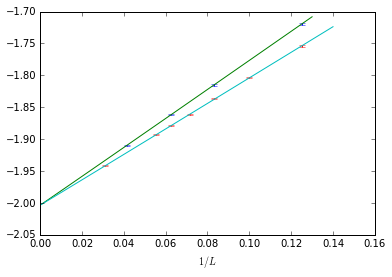

In [211]:
z, w = th[:2]
C = th[2:]

for (s, df), c in zip(qshift_mean.groupby(level='s'), C):
    df.reset_index(inplace=True)
    errorbar(1/df['L'], df['mean'], df['std'], ls='')
    x = linspace(0, xlim()[1])
    plot(x, z + c*x**w)
    
    df.to_csv('../../data/qshift-s{:02d}.csv'.format(int(10*s)), index=False)

xlabel('$1/L$')

In [212]:
params = pd.Series([-th[0], therr[0],
                    th[1], therr[1],
                    th[2], th[3]], 
                   index=['lambda','lambda_err',
                          'omega','omega_err',
                          'C15','C20'])
params

lambda        2.003594
lambda_err    0.004186
omega         1.003809
omega_err     0.039119
C15           2.290558
C20           2.014240
dtype: float64

In [213]:
pd.DataFrame(params).T.to_csv('../../data/qshift.fit.csv', index=False)

In [214]:
Q

0.94830790929261877

# $\chi(T_L)$

In [132]:
chiTL = samples_final.chiTL

In [133]:
chiTL.head()

seed   L 
10052  8     177.388811
       10    268.941604
       12    385.847887
       14    520.876224
       16    677.914816
Name: chiTL, dtype: float64

In [134]:
qchiTL = (chiTL.groupby(level='seed')
               .apply(lambda y: get_quotients(y.reset_index('seed', drop=True))))

In [135]:
qchiTL_mean = qchiTL.groupby(level=['s','L']).agg(['mean','std'])

In [136]:
qchiTL_mean.head()

mean       std
s   L                     
1.5 8   1.923323  0.017971
    12  1.966291  0.016385
    16  2.020732  0.017211
    24  2.129713  0.018667
2.0 8   1.946064  0.010283

In [137]:
qchiTL_cov = qchiTL.unstack(['s','L']).cov()

In [138]:
qchiTL_cov.head()

s                1.5                                         2.0  \
L                 8         12            16        24        8    
s   L                                                              
1.5 8   3.229545e-04 -0.000148  1.717357e-07 -0.000004  0.000109   
    12 -1.476998e-04  0.000268  2.844280e-05 -0.000019  0.000007   
    16  1.717357e-07  0.000028  2.962025e-04 -0.000151 -0.000057   
    24 -3.626511e-06 -0.000019 -1.509037e-04  0.000348 -0.000012   
2.0 8   1.086395e-04  0.000007 -5.675404e-05 -0.000012  0.000106   

s                                                                           
L                 10        12            14        16        18        32  
s   L                                                                       
1.5 8   4.627935e-06 -0.000080  1.254043e-05 -0.000004  0.000004  0.000004  
    12  9.608832e-06  0.000110 -2.344473e-05 -0.000002 -0.000058 -0.000016  
    16  6.456260e-06  0.000116  1.890946e-05  0.000037  0.000012  0.000065  
    24  2.418469e-05 -0.000098  9.840282e-07  0.000020  0.000117 -0.000020  
2.0 8   3.536066e-07  0.000009 -1.346168e-05 -0.000028 -0.000002 -0.000020

In [139]:
def hyp_fix_omega(w):
    def _hypothesis(X, th):
        z, C = th[0], th[1:]
        return array([z + C[i]/L**w for i, (_, L) in zip(X.labels[0], X.values)])
    return _hypothesis

In [215]:
min_size_fit = 10
ifit = (qchiTL_mean.index.get_level_values('L') >= min_size_fit)

X = qchiTL_mean.index[ifit]
y = qchiTL_mean['mean'].iloc[ifit]
W = pinv(qchiTL_cov.iloc[ifit, ifit])
resids2 = sqresids(hyp_fix_omega(0.5))

th, cov = leastsq(resids2, x0=[2.5,1,1], 
                  args=(X, y, W),
                  full_output=True)[:2]


therr = sqrt(diag(cov))
chi2 = sum(resids2(th, X, y, W))
ndf = matrix_rank(W) - len(th)
Q = 1 - stats.chi2.cdf(chi2, ndf)

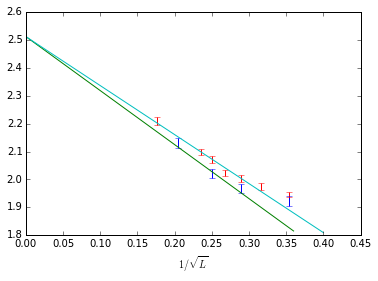

In [216]:
z = th[0]
C = th[1:]

for (s, df), c in zip(qchiTL_mean.groupby(level='s'), C):
    df.reset_index(inplace=True)
    errorbar(df['L']**-0.5, df['mean'], df['std'], ls='')
    x = linspace(0, xlim()[1])
    plot(x, z + c*x)
    
    df.to_csv('../../data/qchiTL-s{:02d}.csv'.format(int(10*s)), index=False)

xlabel('$1/\sqrt{L}$')

In [217]:
Q

0.25088594721661017

In [218]:
th

array([ 2.51214508, -1.93649898, -1.75708568])

In [219]:
therr

array([ 0.01071328,  0.0416164 ,  0.04001703])

In [220]:
params = pd.Series([th[0], therr[0],
                    th[1], th[2]], 
                   index=['yt','yt_err',
                          'C15','C20'])
params

yt        2.512145
yt_err    0.010713
C15      -1.936499
C20      -1.757086
dtype: float64

In [221]:
pd.DataFrame(params).T.to_csv('../../data/qchiTL.fit.csv', index=False)

# Scaling plot

In [222]:
mean_final = samples_final.groupby(level='L').agg(['mean','std'])

In [223]:
mean_final.head()

TL                 chiTL          
        mean       std        mean       std
L                                           
8   8.035576  0.000479  177.025081  1.005039
10  8.269617  0.000299  271.243465  1.482876
12  8.408545  0.000182  386.112772  2.013820
14  8.497737  0.000119  521.689901  2.281362
16  8.558189  0.000079  682.110529  2.649245

In [150]:
chi_final = (chi.groupby(level=['L','Temp'])
                .apply(lambda df: df.sortlevel('LogSweeps').iloc[-1]))

In [151]:
chi_final.head()

mean       sem
L Temp                           
8 7.750308  1819.816863  1.341217
  7.775425  1633.034260  1.472391
  7.800542  1451.576110  1.260678
  7.825659  1278.106107  1.214736
  7.850777  1107.142205  1.345023

In [152]:
# load additional data for wide temperature range

from glob import glob

opts = dict(delim_whitespace=True, comment='#', usecols=range(6),
            names=['bc','d','L','T','chi','chi_err'],
            index_col=['L','T'])

wide = pd.concat([pd.read_csv(f, **opts) for f in glob('f-k0-wide/f-d5-L??.csv')])
chi_wide = wide[['chi','chi_err']]
chi_wide.index.names = ['L','Temp']
chi_wide.columns = ['mean','sem']

In [153]:
dataTc.head()

M2            M4
L Temp    LogSweeps Run                        
8 8.77846 4         0    0.000095  1.986094e-08
                    1    0.000102  1.622421e-08
                    2    0.000250  8.248400e-08
                    3    0.000125  3.724780e-08
                    4    0.000065  9.844944e-09

In [154]:
chiTc = (dataTc.eval('L**5 * M2')
               .groupby(level=['L','Temp','LogSweeps'])
               .agg(['mean','sem'])
               .groupby(level=['L','Temp'])
               .apply(lambda df: df.sortlevel('LogSweeps').iloc[-1]))

In [155]:
chi_all = pd.concat((chi_final, chi_wide, chiTc)).sortlevel()

In [156]:
chi_all = chi_all.join(mean_final)
chi_all.columns = ['_'.join(c) if isinstance(c, tuple) else c 
                   for c in chi_all.columns]
chi_all.head()

mean       sem   TL_mean    TL_std  chiTL_mean  chiTL_std
L Temp                                                                   
8 7.023  8769.542912  2.119351  8.035576  0.000479  177.025081   1.005039
  7.068  8300.096922  2.358131  8.035576  0.000479  177.025081   1.005039
  7.114  7810.897971  2.422048  8.035576  0.000479  177.025081   1.005039
  7.159  7338.777446  2.516133  8.035576  0.000479  177.025081   1.005039
  7.205  6859.964979  2.045863  8.035576  0.000479  177.025081   1.005039

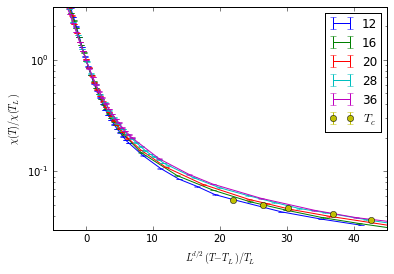

In [157]:
chi_all_ = chi_all.query('L==[12,16,20,28,36]')
chi_all_Tc = chi_all_.query('Temp > 8.77845 & Temp < 8.77847')
chi_all_ = chi_all_.query('Temp < 8.77845 | Temp > 8.77847')

for L, df in chi_all_.groupby(level='L'):
    x = df.eval('L**2.5 * (Temp - TL_mean)/TL_mean')
    y = df.eval('mean/chiTL_mean')
    yerr = df.eval('sem/chiTL_mean')
    errorbar(x, y, yerr, label='{}'.format(L))
    
    df.to_csv('../../data/chi_TL-f-L{:02d}.csv'.format(L))
    
df = chi_all_Tc
x = df.eval('L**2.5 * (Temp - TL_mean)/TL_mean')
y = df.eval('mean/chiTL_mean')
yerr = df.eval('sem/chiTL_mean')
errorbar(x, y, yerr, marker='o', ls='', label='$T_c$')

df.to_csv('../../data/chi_TL-f-Tc.csv'.format(L))
    
yscale('log')
xlim(-5, 45)
ylim(0.03, 3)
xlabel('$L^{d/2}(T-T_L)/T_L$')
ylabel('$\chi(T)/\chi(T_L)$')
legend()

# $\delta T_L$ (width)

In [158]:
def width(G, g1=0.75, g2=0.25):
    try:
        f = UnivariateSpline(G.index, G['mean'], w=1./G['sem'])
        T1, T2 = [bisect(lambda T: g - f(T), G.index[0], G.index[-1]) for g in [g1, g2]]
        return T2 - T1
    except ValueError as e:
        return nan

In [159]:
G_ = G.xs([32,10], level=['L','LogSweeps'])

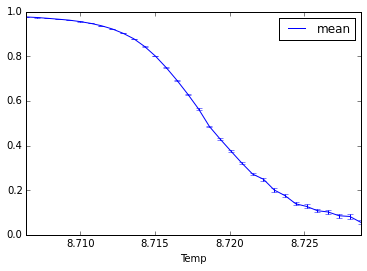

In [160]:
G_.plot(y='mean', yerr='sem')

In [161]:
width(G_)

0.006185864739967073

In [162]:
def compute_width(data):
    G = data.groupby(level=['L','Temp','LogSweeps']).apply(binderG)
    result = (G.groupby(level=['L','LogSweeps'])
               .apply(lambda df: width(df.reset_index(['L','LogSweeps']))))
    return result

In [163]:
data.head()

M2        M4
L Temp     LogSweeps Run                    
8 7.750308 4         0    0.054738  0.003106
                     1    0.056092  0.003275
                     2    0.053007  0.002916
                     3    0.044488  0.002058
                     4    0.059542  0.003698

In [ ]:
time compute_width(data).head()

In [ ]:
seeds = random_integers(1e5, size=100)
bs = BootstrapSampler(data, ['L','Temp','LogSweeps'], compute_width)

with mp.Pool(4) as p:
    samples = p.map(bs, seeds)

samples = pd.concat(samples, keys=seeds, names=['seed'])

In [ ]:
#samples.to_hdf('width-samples.h5','samples')

In [165]:
samples = pd.read_hdf('width-samples.h5','samples')

In [166]:
samples.head()

seed  L  LogSweeps
2057  8  4            0.141148
         5            0.144542
         6            0.137473
         7            0.142870
         8            0.143321
dtype: float64

In [169]:
width = (samples.groupby(level=['L','seed'], group_keys=False)
                .apply(get_final))

In [170]:
qwidth = (width.groupby(level='seed')
               .apply(lambda y: get_quotients(y.reset_index('seed', drop=True))))

In [171]:
qwidth_mean = qwidth.groupby(level=['s','L']).agg(['mean','std'])

In [172]:
qwidth_cov = qwidth.unstack(['s','L']).cov()

In [224]:
X = qwidth_mean.index
y = qwidth_mean['mean']
W = pinv(qwidth_cov)
resids2 = sqresids(hyp_fix_omega(1))

th, cov = leastsq(resids2, x0=[-2.5,1,1], 
                  args=(X, y, W),
                  full_output=True)[:2]


therr = sqrt(diag(cov))
chi2 = sum(resids2(th, X, y, W))
ndf = matrix_rank(W) - len(th)
Q = 1 - stats.chi2.cdf(chi2, ndf)

In [225]:
th

array([-2.44671272,  2.38495015,  2.01371165])

In [226]:
therr

array([ 0.01166539,  0.14380421,  0.16892204])

In [227]:
Q

0.71261140408351076

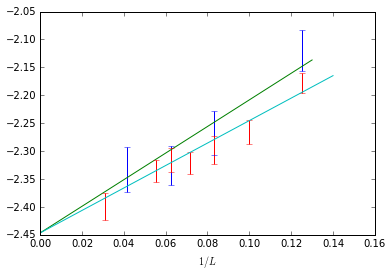

In [228]:
z = th[0]
C = th[1:]
w = 1

for (s, df), c in zip(qwidth_mean.groupby(level='s'), C):
    df.reset_index(inplace=True)
    errorbar(1/df['L'], df['mean'], df['std'], ls='')
    x = linspace(0, xlim()[1])
    plot(x, z + c*x**w)
    
    df.to_csv('../../data/qwidth-s{:02d}.csv'.format(int(10*s)), index=False)

xlabel('$1/L$')

In [229]:
params = pd.Series([-th[0], therr[0],
                    th[1], th[2]], 
                   index=['yt','yt_err',
                          'C15','C20'])
params

yt        2.446713
yt_err    0.011665
C15       2.384950
C20       2.013712
dtype: float64

In [230]:
pd.DataFrame(params).T.to_csv('../../data/qwidth.fit.csv', index=False)

# $\chi(T_c)$

In [253]:
dataTc.head()

M2            M4
L Temp    LogSweeps Run                        
8 8.77846 4         0    0.000095  1.986094e-08
                    1    0.000102  1.622421e-08
                    2    0.000250  8.248400e-08
                    3    0.000125  3.724780e-08
                    4    0.000065  9.844944e-09

In [254]:
# get new data

def get_size_seed(f):
    L = int(re.search('L(\d\d)', f).group(1))
    seed = int(re.search('(\d{4})\.data\.txt', f).group(1))
    return L, seed

def make_consecutive_run(start=0):
    def _(df):
        seed = df.reset_index()['seed']
        run = pd.Index(seed.rank('dense').astype(int) + start - 1, name='Run')
        return df.reset_index('seed', drop=True).set_index(run, append=True)
    return _

kw = dict(delim_whitespace=True, index_col=['Temp','LogSweeps'])

extra = pd.concat({get_size_seed(f): pd.read_table(f, **kw)
                   for f in glob('f-k0-Tc/*.data.txt')}, names=['L','seed'])

extra = extra[['M2','M4']]

extra = (extra.groupby(level='L', group_keys=False)
              .apply(make_consecutive_run(0))
              .sortlevel())

extra_ = extra.reset_index('Run')
extra_['Run'] += 50
extra = pd.concat((extra, extra_.set_index('Run', append=True)))

In [233]:
extra.head()

M2        M4
L  Temp    LogSweeps Run                    
48 8.77846 3         0    0.019039  0.000722
                     1    0.025554  0.001017
                     2    0.040262  0.002000
                     3    0.023024  0.000784
                     4    0.024666  0.000896

In [271]:
dataTc_ = pd.concat((dataTc, extra))

In [255]:
dataTc_ = dataTc

In [273]:
chiTc = (dataTc_.eval('L**5 * M2')
                .reset_index('Temp', drop=True))

In [284]:
chiTc.head()

L  LogSweeps  Run
8  4          0      3.098694
              1      3.356597
              2      8.208312
              3      4.097717
              4      2.125229
dtype: float64

In [300]:
def get_mean(df):
    return df.groupby(level=['L','LogSweeps']).mean()

seeds = pd.Index(random_integers(1e5, size=100), name='seed')
bs = BootstrapSampler(chiTc, ['L','LogSweeps'], get_mean)

with mp.Pool(4) as p:
    samples = p.map(bs, seeds)

samples = pd.concat(samples, keys=seeds, names=['seed'])

In [323]:
samples.head()

seed   L  LogSweeps
84253  8  4            11.214308
          5            12.434538
          6            11.972600
          7            11.573935
          8            12.046746
dtype: float64

In [324]:
samples_final = (samples.groupby(level='L', group_keys=False)
                        .apply(get_final)).sortlevel()

In [325]:
qchiTc = (samples_final.groupby(level='seed')
                       .apply(lambda y: get_quotients(y.reset_index('seed', drop=True))))

In [326]:
qchiTc.head()

seed  s    L 
331   1.5  8     1.501826
           12    1.598936
           16    1.654402
           24    1.749513
           32    1.798688
Name: Q, dtype: float64

In [335]:
qchiTc_mean = qchiTc.groupby(level=['s','L']).agg(['mean','std'])

In [336]:
qchiTc_cov = qchiTc.unstack(['s','L']).cov()

In [337]:
def hyp_fix_omega_quad(w):
    def _hypothesis(X, th):
        z, C, D = th[0], th[1::2], th[2::2]
        return array([z + C[i]/L**w + D[i]/L**(2*w) 
                      for i, (_, L) in zip(X.labels[0], X.values)])
    return _hypothesis

In [338]:
X = qchiTc_mean.index
y = qchiTc_mean['mean']
W = pinv(qchiTc_cov)
#W = diag(1/qchiTc_mean['sem']**2) # neglect correlations
resids2 = sqresids(hyp_fix_omega_quad(1))

th, cov = leastsq(resids2, x0=[2,1,1,1,1], 
                  args=(X, y, W),
                  full_output=True)[:2]

therr = sqrt(diag(cov))
chi2 = sum(resids2(th, X, y, W))
ndf = matrix_rank(W) - len(th)
Q = 1 - stats.chi2.cdf(chi2, ndf)

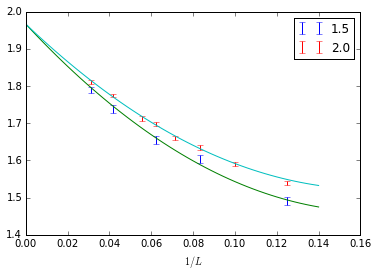

In [346]:
z = th[0]
C = th[1::2]
D = th[2::2]
w = 1

for (s, df), c, d in zip(qchiTc_mean.groupby(level='s'), C, D):
    df.reset_index(inplace=True)
    errorbar(1/df['L'], df['mean'], df['std'], 
             label='{}'.format(s), ls='')
    x = linspace(0, xlim()[1])
    plot(x, z + c*x**w + d*x**(2*w))
    
    df.to_csv('../../data/qchiTc-s{:02d}.csv'.format(int(10*s)), index=False)

xlabel('$1/L$')
legend()

In [341]:
th

array([  1.96674726,  -6.04687849,  18.09460331,  -5.37737618,  16.25925612])

In [342]:
therr

array([ 0.01204773,  0.30823047,  1.78976873,  0.39372403,  2.67087824])

In [343]:
Q

0.40021221155632958

In [344]:
params = pd.Series([th[0], therr[0]] + list(th[1:]),
                   index=['yt','yt_err',
                          'C15','D15',
                          'C20','D20'])
params

yt         1.966747
yt_err     0.012048
C15       -6.046878
D15       18.094603
C20       -5.377376
D20       16.259256
dtype: float64

In [345]:
pd.DataFrame(params).T.to_csv('../../data/qchiTc.fit.csv', index=False)